# Machine Learning Model: Anomaly & Recommender System

In [1]:
from __future__ import division

import re
import scipy as sp
import scipy.io
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

# 1 Anomaly detection

In [2]:
data_1_dict = scipy.io.loadmat('data/dataset1.mat')

In [3]:
X = data_1_dict['X']
X_val = data_1_dict['Xval']
y_val = data_1_dict['yval'].T[0]

M = len(X)
M_val = len(X_val)

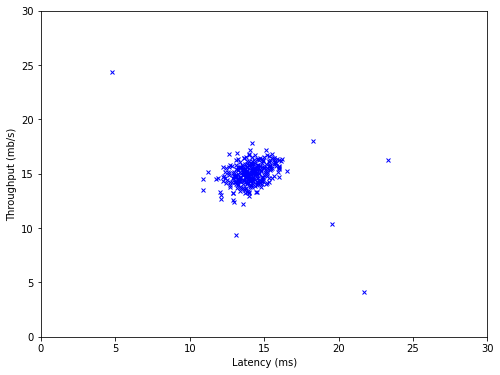

In [4]:
plt.figure(figsize=(8, 6))
plt.plot(X.T[0], X.T[1], 'bx', ms=4)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.savefig('plots/fig1.jpg')
plt.show()

## 1.1 Gaussian distribution

The function "multivariate_normal" imported from scipy.stats above will be used in place of "multivariateGaussian.m"

## 1.2 Estimating parameters for a Gaussian

In [5]:
def estimate_gaussian(X):
    mu = sp.mean(X, axis=0)
    var = sp.var(X, axis=0, ddof=1)
    return mu, var

In [6]:
mu, var = estimate_gaussian(X)

<ipython-input-5-dd8ef014e422>:2: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  mu = sp.mean(X, axis=0)
<ipython-input-5-dd8ef014e422>:3: DeprecationWarning: scipy.var is deprecated and will be removed in SciPy 2.0.0, use numpy.var instead
  var = sp.var(X, axis=0, ddof=1)


In [7]:
rv = multivariate_normal(mu, sp.diag(var))

<ipython-input-7-6c01a3e70c6e>:1: DeprecationWarning: scipy.diag is deprecated and will be removed in SciPy 2.0.0, use numpy.diag instead
  rv = multivariate_normal(mu, sp.diag(var))


In [8]:
xs, ys = sp.mgrid[0:30:0.1, 0:30:0.1]
pos = sp.empty(xs.shape + (2,))
pos[:, :, 0] = xs
pos[:, :, 1] = ys

<ipython-input-8-251a7dabbf22>:2: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  pos = sp.empty(xs.shape + (2,))


<ipython-input-9-bf083a871bd5>:3: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  plt.contour(xs, ys, rv.pdf(pos), 10.**sp.arange(-21, -2, 3))


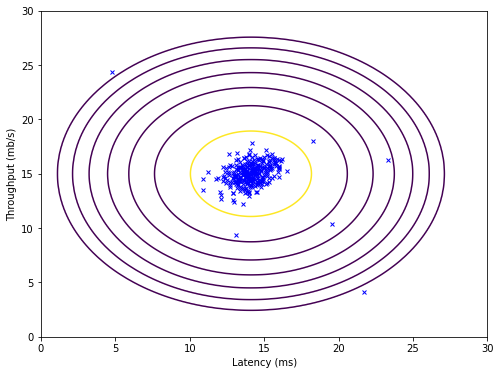

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(X.T[0], X.T[1], 'bx', ms=4)
plt.contour(xs, ys, rv.pdf(pos), 10.**sp.arange(-21, -2, 3))
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.savefig('plots/fig2.jpg')
plt.show()

## 1.3 Selecting the threshold, $\epsilon$

In [10]:
p_val = rv.pdf(X_val)

In [11]:
def select_threshold(y_val, p_val):
    best_epsilon, best_F1 = 0, 0
    step_size = (max(p_val) - min(p_val)) / 1000
    for epsilon in sp.arange(min(p_val), max(p_val), step_size)[1:]:
        cv_predictions = p_val < epsilon
        tp = sp.sum((cv_predictions == 1) & (y_val == 1))
        fp = sp.sum((cv_predictions == 1) & (y_val == 0))
        fn = sp.sum((cv_predictions == 0) & (y_val == 1))
        tn = sp.sum((cv_predictions == 0) & (y_val == 0))
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        
        F1 = 2 * prec * rec / (prec + rec)
        if F1 > best_F1:
            best_epsilon = epsilon
            best_F1 = F1
    return best_epsilon, best_F1

In [12]:
best_epsilon, best_F1 = select_threshold(y_val, p_val)
print("best epsilon =", best_epsilon)

best epsilon = 8.961567687193517e-05
<ipython-input-11-35af45ae8636>:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  for epsilon in sp.arange(min(p_val), max(p_val), step_size)[1:]:
<ipython-input-11-35af45ae8636>:6: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  tp = sp.sum((cv_predictions == 1) & (y_val == 1))
<ipython-input-11-35af45ae8636>:7: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  fp = sp.sum((cv_predictions == 1) & (y_val == 0))
<ipython-input-11-35af45ae8636>:8: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  fn = sp.sum((cv_predictions == 0) & (y_val == 1))
<ipython-input-11-35af45ae8636>:9: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  tn = sp.sum((cv_predictions == 0) & (y_val == 0

In [13]:
outliers = X[rv.pdf(X) < best_epsilon]

<ipython-input-14-b1e873bce94c>:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  plt.contour(xs, ys, rv.pdf(pos), 10.**sp.arange(-21, -2, 3))


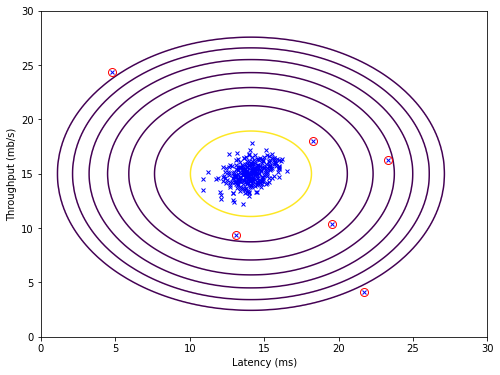

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(X.T[0], X.T[1], 'bx', ms=4)
plt.plot(outliers.T[0], outliers.T[1], 'ro', ms=8, mfc='none', mec='r')
plt.contour(xs, ys, rv.pdf(pos), 10.**sp.arange(-21, -2, 3))
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.savefig('plots/fig3.jpg')
plt.show()

## 1.4 High dimensional dataset

In [15]:
data_2_dict = scipy.io.loadmat('data/dataset2.mat')

In [16]:
X = data_2_dict['X']
X_val = data_2_dict['Xval']
y_val = data_2_dict['yval'].T[0]

M = len(X)
M_val = len(X_val)

In [17]:
mu, var = estimate_gaussian(X)
rv = multivariate_normal(mu, sp.diag(var))
p_val = rv.pdf(X_val)
best_epsilon, best_F1 = select_threshold(y_val, p_val)
outliers = X[rv.pdf(X) < best_epsilon]

<ipython-input-5-dd8ef014e422>:2: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  mu = sp.mean(X, axis=0)
<ipython-input-5-dd8ef014e422>:3: DeprecationWarning: scipy.var is deprecated and will be removed in SciPy 2.0.0, use numpy.var instead
  var = sp.var(X, axis=0, ddof=1)
<ipython-input-17-8df847e15b66>:2: DeprecationWarning: scipy.diag is deprecated and will be removed in SciPy 2.0.0, use numpy.diag instead
  rv = multivariate_normal(mu, sp.diag(var))
<ipython-input-11-35af45ae8636>:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  for epsilon in sp.arange(min(p_val), max(p_val), step_size)[1:]:
<ipython-input-11-35af45ae8636>:6: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  tp = sp.sum((cv_predictions == 1) & (y_val == 1))
<ipython-input-11-35af45ae8636>:7: DeprecationWarning: scipy.sum is deprecated and 

In [18]:
print("best epsilon = ", best_epsilon)
print("best F1 =", best_F1)
print("number of outliers =", len(outliers))

best epsilon =  1.371660675040733e-18
best F1 = 0.6153846153846154
number of outliers = 117


# 2 Recommender systems

In [19]:
data_movies_dict = scipy.io.loadmat('data/movies.mat')

In [20]:
Y = data_movies_dict['Y']
R = data_movies_dict['R']

In [21]:
data_movie_ids = sp.loadtxt('data/movie_ids.txt', dtype=str, delimiter='\n')

<ipython-input-21-896a6dc6f95c>:1: DeprecationWarning: scipy.loadtxt is deprecated and will be removed in SciPy 2.0.0, use numpy.loadtxt instead
  data_movie_ids = sp.loadtxt('data/movie_ids.txt', dtype=str, delimiter='\n')


In [22]:
index_movie_list = [re.split(' ', row, maxsplit=1) for row in data_movie_ids]
movie_index_dict = {movie: int(index) - 1 for index, movie in index_movie_list}

### 2.1 Movie ratings dataset

In [23]:
index = movie_index_dict['Toy Story (1995)']
print(sp.mean(Y[index][R[index] == 1]))

3.8783185840707963
<ipython-input-23-432ac492ccbb>:2: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  print(sp.mean(Y[index][R[index] == 1]))


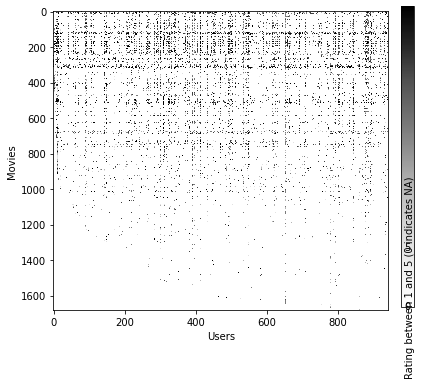

In [24]:
fig = plt.figure(figsize=(6,6))
imshow_out = plt.imshow(Y, cmap=plt.get_cmap('Greys'), vmin=0, vmax=5, interpolation = 'nearest', aspect=0.5)
plt.xlabel('Users')
plt.ylabel('Movies')

ax_cb = fig.add_axes([0.93, 0.165, 0.03, 0.695])
markersize = plt.rcParams['lines.markersize'] # The adjustments to 'lines.markersize' in this code block prevent points of size "markersize" from appearing in the corners of the colorbar.
plt.rcParams['lines.markersize'] = 0.1 
fig.colorbar(imshow_out, cax=ax_cb, ticks=[])
ax_cb.text(1.2, 0.010, '0', verticalalignment='center', horizontalalignment='left')
ax_cb.text(1.2, 0.985, '5', verticalalignment='center', horizontalalignment='left')
ax_cb.text(1.4, 0.5, 'Rating between 1 and 5 (0 indicates NA)', verticalalignment='center', horizontalalignment='left', rotation=90)
plt.rcParams['lines.markersize'] = markersize

## 2.2 Collaborative filtering learning algorithm

### 2.2.1 Collaborative filtering cost function

In [25]:
movies_params_dict = scipy.io.loadmat('data/movieParams.mat')

In [26]:
X = movies_params_dict['X']
Theta = movies_params_dict['Theta']

In [27]:
def cofi_cost_func(params, Y, R, num_users, num_movies, num_features):
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)
    cost = 1 / 2 * sp.sum((R * X.dot(Theta.T) - Y)**2)
    return cost

In [28]:
# Cost function and gradients will be tested on a subset of the data.
num_features = 3
num_users = 4
num_movies = 5

X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

params = sp.hstack((X.ravel(), Theta.ravel()))

<ipython-input-28-da439f801bba>:11: DeprecationWarning: scipy.hstack is deprecated and will be removed in SciPy 2.0.0, use numpy.hstack instead
  params = sp.hstack((X.ravel(), Theta.ravel()))


In [29]:
print("Cost at loaded parameters:", cofi_cost_func(params, Y, R, num_users, num_movies, num_features))

Cost at loaded parameters: 22.224603725685675
<ipython-input-27-02a0cc3df791>:4: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  cost = 1 / 2 * sp.sum((R * X.dot(Theta.T) - Y)**2)


### 2.2.2 Collaborative filtering gradient

In [30]:
def cofi_cost_grad_func(params, Y, R, num_users, num_movies, num_features):
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)
    cost = 1 / 2 * sp.sum((R * X.dot(Theta.T) - Y)**2)
    X_grad = (R * X.dot(Theta.T) - Y).dot(Theta)
    Theta_grad = (R * X.dot(Theta.T) - Y).T.dot(X)
    return cost, sp.concatenate((X_grad.ravel(), Theta_grad.ravel()))

Gradient checking.

In [31]:
eps = 1e-6

In [32]:
cost_0 = cofi_cost_func(params, Y, R, num_users, num_movies, num_features)

<ipython-input-27-02a0cc3df791>:4: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  cost = 1 / 2 * sp.sum((R * X.dot(Theta.T) - Y)**2)


In [33]:
def cofi_numerical_grad(params, Y, R, num_users, num_movies, num_features):
    numerical_grad = sp.zeros(len(params))
    unit_vector = sp.zeros(len(params))
    for i in range(len(params)):
        unit_vector[i] = eps
        numerical_grad[i] = (cofi_cost_func(params + unit_vector, Y, R, num_users, num_movies, num_features) - cost_0) / eps
        unit_vector[i] = 0
    return numerical_grad

In [34]:
diff = cofi_cost_grad_func(params, Y, R, num_users, num_movies, num_features)[1] \
    - cofi_numerical_grad(params, Y, R, num_users, num_movies, num_features)

<ipython-input-30-04be608ef0e1>:4: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  cost = 1 / 2 * sp.sum((R * X.dot(Theta.T) - Y)**2)
<ipython-input-30-04be608ef0e1>:7: DeprecationWarning: scipy.concatenate is deprecated and will be removed in SciPy 2.0.0, use numpy.concatenate instead
  return cost, sp.concatenate((X_grad.ravel(), Theta_grad.ravel()))
<ipython-input-33-bb36f17e07e4>:2: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  numerical_grad = sp.zeros(len(params))
<ipython-input-33-bb36f17e07e4>:3: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  unit_vector = sp.zeros(len(params))


In [35]:
sp.sum(abs(diff) < 1e-5) == len(diff)

<ipython-input-35-4411c7525ed5>:1: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  sp.sum(abs(diff) < 1e-5) == len(diff)


True

### 2.2.3 Regularized cost function

In [36]:
def cofi_cost_func_reg(params, Y, R, num_users, num_movies, num_features, lam):
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)
    cost = 1 / 2 * sp.sum((R * X.dot(Theta.T) - Y)**2) + lam / 2 * sp.sum(X**2) + lam / 2 * sp.sum(Theta**2)
    return cost

In [37]:
lam = 1.5
print("Regularized cost at loaded parameters:", \
    cofi_cost_func_reg(params, Y, R, num_users, num_movies, num_features, 1.5))

Regularized cost at loaded parameters: 31.344056244274217
<ipython-input-36-30629c1f2431>:4: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  cost = 1 / 2 * sp.sum((R * X.dot(Theta.T) - Y)**2) + lam / 2 * sp.sum(X**2) + lam / 2 * sp.sum(Theta**2)


### 2.2.4 Regularized gradient

In [38]:
def cofi_cost_grad_func_reg(params, Y, R, num_users, num_movies, num_features, lam):
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)
    cost = 1 / 2 * sp.sum((R * X.dot(Theta.T) - Y)**2)
    X_grad = (R * X.dot(Theta.T) - Y).dot(Theta) + lam * X
    Theta_grad = (R * X.dot(Theta.T) - Y).T.dot(X) + lam * Theta
    return cost, sp.concatenate((X_grad.ravel(), Theta_grad.ravel()))

Gradient checking.

In [39]:
eps = 1e-6

In [40]:
cost_0 = cofi_cost_func_reg(params, Y, R, num_users, num_movies, num_features, lam)

<ipython-input-36-30629c1f2431>:4: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  cost = 1 / 2 * sp.sum((R * X.dot(Theta.T) - Y)**2) + lam / 2 * sp.sum(X**2) + lam / 2 * sp.sum(Theta**2)


In [41]:
def cofi_numerical_grad_reg(params, Y, R, num_users, num_movies, num_features, lam):
    numerical_grad = sp.zeros(len(params))
    unit_vector = sp.zeros(len(params))
    for i in range(len(params)):
        unit_vector[i] = eps
        numerical_grad[i] = \
            (cofi_cost_func_reg(params + unit_vector, Y, R, num_users, num_movies, num_features, lam) - cost_0) / eps
        unit_vector[i] = 0
    return numerical_grad

In [42]:
diff = cofi_cost_grad_func_reg(params, Y, R, num_users, num_movies, num_features, lam)[1] \
    - cofi_numerical_grad_reg(params, Y, R, num_users, num_movies, num_features, lam)

<ipython-input-38-f8732271fbae>:4: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  cost = 1 / 2 * sp.sum((R * X.dot(Theta.T) - Y)**2)
<ipython-input-38-f8732271fbae>:7: DeprecationWarning: scipy.concatenate is deprecated and will be removed in SciPy 2.0.0, use numpy.concatenate instead
  return cost, sp.concatenate((X_grad.ravel(), Theta_grad.ravel()))
<ipython-input-41-ccd160e21d39>:2: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  numerical_grad = sp.zeros(len(params))
<ipython-input-41-ccd160e21d39>:3: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  unit_vector = sp.zeros(len(params))


In [43]:
sp.sum(abs(diff) < 1e-5) == len(diff)

<ipython-input-43-4411c7525ed5>:1: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  sp.sum(abs(diff) < 1e-5) == len(diff)


True

## 2.3 Learning movie recommendations

In [44]:
Y = data_movies_dict['Y']
R = data_movies_dict['R']

In [45]:
num_movies, num_users = Y.shape
num_features = 10

In [46]:
my_ratings = sp.zeros(num_movies)

my_ratings[1-1] = 4
my_ratings[98-1] = 2
my_ratings[7-1] = 3
my_ratings[12-1]= 5
my_ratings[54-1] = 4
my_ratings[64-1]= 5
my_ratings[66-1]= 3
my_ratings[69-1] = 5
my_ratings[183-1] = 4
my_ratings[226-1] = 5
my_ratings[355-1] = 5

<ipython-input-46-cf117b48447e>:1: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  my_ratings = sp.zeros(num_movies)


In [47]:
Y = sp.hstack((my_ratings.reshape(-1, 1), Y))
R = sp.hstack(((my_ratings != 0).reshape(-1, 1), R))
num_movies, num_users = Y.shape

<ipython-input-47-aae9deb37b57>:1: DeprecationWarning: scipy.hstack is deprecated and will be removed in SciPy 2.0.0, use numpy.hstack instead
  Y = sp.hstack((my_ratings.reshape(-1, 1), Y))
<ipython-input-47-aae9deb37b57>:2: DeprecationWarning: scipy.hstack is deprecated and will be removed in SciPy 2.0.0, use numpy.hstack instead
  R = sp.hstack(((my_ratings != 0).reshape(-1, 1), R))


In [48]:
print('New user ratings:')
for rating, (index, movie) in zip(my_ratings, index_movie_list):
    if rating > 0: 
        print('Rated %d for %s' % (rating, movie))

New user ratings:
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 4 for Alien (1979)
Rated 5 for Die Hard 2 (1990)
Rated 5 for Sphere (1998)


### 2.3.1 Recommendations

In [49]:
X = sp.random.normal(size=(num_movies, num_features))
Theta = sp.random.normal(size=(num_users, num_features))

In [50]:
lam = 10
params = sp.hstack((X.ravel(), Theta.ravel()))

res = minimize(cofi_cost_grad_func_reg, params, 
               method='TNC', args=(Y, R, num_users, num_movies, num_features, lam), 
               jac=True, options = {'maxiter': 1000}) # Takes ~10sec to run on my laptop.

<ipython-input-50-1f86509a5fa0>:2: DeprecationWarning: scipy.hstack is deprecated and will be removed in SciPy 2.0.0, use numpy.hstack instead
  params = sp.hstack((X.ravel(), Theta.ravel()))
<ipython-input-38-f8732271fbae>:4: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  cost = 1 / 2 * sp.sum((R * X.dot(Theta.T) - Y)**2)
<ipython-input-38-f8732271fbae>:7: DeprecationWarning: scipy.concatenate is deprecated and will be removed in SciPy 2.0.0, use numpy.concatenate instead
  return cost, sp.concatenate((X_grad.ravel(), Theta_grad.ravel()))


In [51]:
res

     fun: 31742.46102480465
     jac: array([-5.77399397,  4.1620011 ,  3.38100164, ...,  1.32169325,
        0.62199224, -0.80393681])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 294
     nit: 16
  status: 1
 success: True
       x: array([-0.51037854, -0.24156659, -1.19673388, ...,  0.43976871,
       -0.10304751, -1.04057407])

In [52]:
params = res['x']

In [53]:
X = params[:num_movies * num_features].reshape(num_movies, num_features)
Theta = params[num_movies * num_features:].reshape(num_users, num_features)

In [54]:
my_predictions = X.dot(Theta.T)[:, 0]

In [55]:
print('Top recommendations for you:')
for index in my_predictions.argsort()[::-1][:15]:
    print('Predicting rating %.1f for movie %s' % (my_predictions[index], index_movie_list[index][1]))

print('')

print('Original ratings provided:')
for rating, (index, movie) in zip(my_ratings, index_movie_list):
    if rating > 0: 
        print('Rated %d for %s' % (rating, movie))

Top recommendations for you:
Predicting rating 4.3 for movie Titanic (1997)
Predicting rating 4.1 for movie Star Wars (1977)
Predicting rating 4.0 for movie Raiders of the Lost Ark (1981)
Predicting rating 3.9 for movie Good Will Hunting (1997)
Predicting rating 3.9 for movie Shawshank Redemption, The (1994)
Predicting rating 3.9 for movie Braveheart (1995)
Predicting rating 3.8 for movie Return of the Jedi (1983)
Predicting rating 3.8 for movie Empire Strikes Back, The (1980)
Predicting rating 3.8 for movie Schindler's List (1993)
Predicting rating 3.8 for movie Terminator 2: Judgment Day (1991)
Predicting rating 3.8 for movie Godfather, The (1972)
Predicting rating 3.7 for movie L.A. Confidential (1997)
Predicting rating 3.7 for movie Usual Suspects, The (1995)
Predicting rating 3.7 for movie As Good As It Gets (1997)
Predicting rating 3.7 for movie Terminator, The (1984)

Original ratings provided:
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Susp